# Notebook to train and test U-Net on TCD_ML

## Install Prereqs

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install tensorflow_datasets
!pip install matplotlib
!pip install pillow

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


## Imports and Configs

Prerequisites:
* Install Tensorflow package
* Install tensorflow_datasets package

If tensorflow_examples is not installed:
https://medium.com/@arthurlee_73761/how-to-solve-cannot-found-tensorflow-examples-bac00be8fcbd

My file directory is set up like:
```
Root/
|---TCDDatasetGen.ipynb
|---test2.ipynb
|---GPU_Enabled/
    |---test2-GPU.ipynb
|---Data/
    |---PreprocessedImages/
        |(ALL IMAGES)
        |---Dataset/
            |---BetaMap/
                  |---Training/
                        |(ALL TRAINING BETA MAPS)
                  |---Validation/
                        |(ALL VALIDATION BETA MAPS)
            |---TCDEncoded/
                  |---Training/
                        |(ALL TRAINING ENCODINGS)
                  |---Validation/
                        |(ALL VALIDATION ENCODINGS)
```

In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

from tensorflow.keras.callbacks import EarlyStopping

dataset_path = '../Data/Dataset/SCDEncoded/'
map_path = '../Data/Dataset/BetaMap/'
models_path = '../Models/'
model_name = 'U-Net_Faces_SCD'
training_data = 'Training/'
val_data = 'Testing/'

## Check GPU Running and Configs

From [here](https://github.com/tensorflow/tensorflow/issues/43174#issuecomment-691657692)

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## CONFIGS

In [4]:
TRAINSET_SIZE = len(os.listdir(dataset_path + training_data))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
VALSET_SIZE = len(os.listdir(dataset_path + val_data))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")


# DATASET PARAMETERS
SEED = 123
TRAIN_LENGTH = TRAINSET_SIZE
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# MODEL PARAMETERS
OUTPUT_CHANNELS = 5

# TRAINING PARAMETERS
EPOCHS = 1000
VAL_SUBSPLITS = 5 # CURRENTLY UNUSED
VALIDATION_STEPS = VALSET_SIZE//BATCH_SIZE//VAL_SUBSPLITS # CURRENTLY UNUSED

# CONFIGURE EARLY STOPPING
es = EarlyStopping(monitor = 'val_loss', mode ='min', verbose = 1)

The Training Dataset contains 919 images.
The Validation Dataset contains 230 images.


## Define Helper Functions (parse image, normalize, load image for train or test, display image)

In [5]:
def parse_image(img_path: str) -> dict:
    """
    Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3, dtype=tf.dtypes.uint8)

    mask_path = tf.strings.regex_replace(img_path, 'SCDEncoded', 'BetaMap')
    mask_path = tf.strings.regex_replace(mask_path, '_SCD_Encoded', '_SCD_Encoded_Beta_Map')
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)

    return {'image': image, 'segmentation_mask': mask}

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    ### Don't resize, crop instead! :^) 
    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], 512, 512)
    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], 512, 512)
    #input_image = add_gaussian_blur(input_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], 512, 512)
    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], 512, 512)
    #input_image = add_gaussian_blur(input_image)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def add_gaussian_blur(image):
    image = tf.expand_dims(image, -1)
    blur = [tf.divide(tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype = tf.float32), 16.0)]
    blur = tf.expand_dims(blur, axis = -1)
    blur = tf.transpose(blur, [1,2,3,0])
    blurred_image = tf.nn.conv2d(image, blur, strides = (1,1), padding = 'SAME')[:,:,:,0]
    return blurred_image

## Define Helper Functions for displaying images and creating mask

In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        # plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

## Setup Training and Validation Datasets

In [7]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.png", seed=SEED)
val_dataset = val_dataset.map(parse_image)

dataset = {"train": train_dataset, "val": val_dataset}

train = dataset['train'].map(load_image_train)
test = dataset['val'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BUFFER_SIZE)
test_dataset = test.batch(BATCH_SIZE)

## Retrieve and display sample image

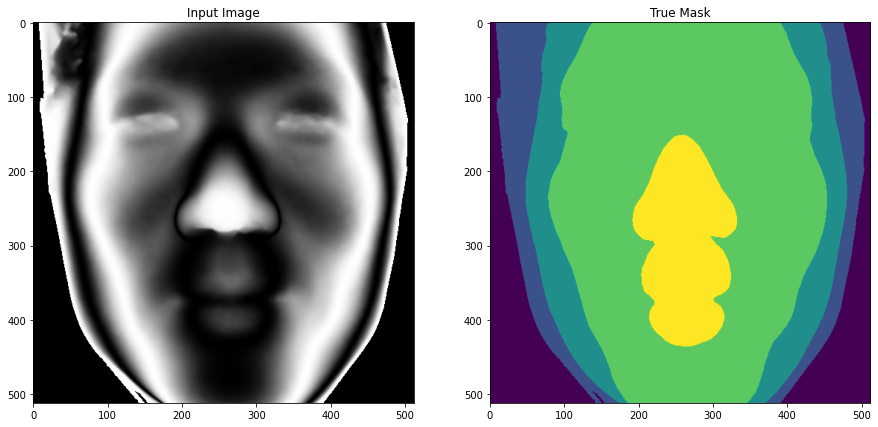

In [8]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Setup Network

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(512, 512, 3), include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

9412608/9406464 [==============================] - 1s 0us/step


## Create model function

In [10]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Create model

In [11]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Show current predictions

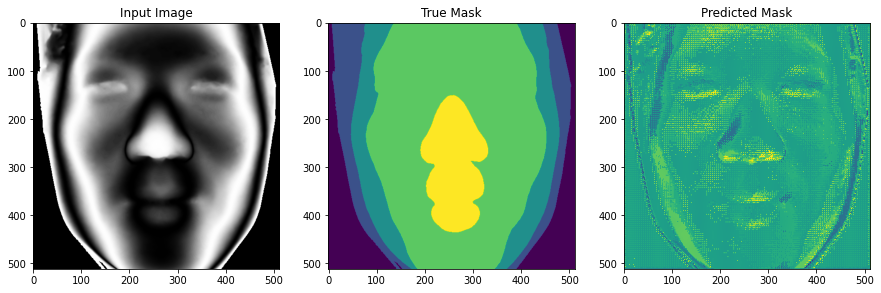

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.uint8)>
<BatchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.uint8)>


In [12]:
show_predictions()
print(train_dataset)
print(test_dataset)

## Fit dataset and show new predictions

In [13]:
model_history = model.fit(train_dataset, validation_data = test_dataset, epochs=70) #, callbacks = es)

show_predictions(test_dataset, 3)

Epoch 1/70
29/29 [==============================] - 4s 137ms/step - loss: 0.9959 - accuracy: 0.6390 - val_loss: 0.5377 - val_accuracy: 0.8040
Epoch 2/70
29/29 [==============================] - 2s 81ms/step - loss: 0.3494 - accuracy: 0.8927 - val_loss: 0.3232 - val_accuracy: 0.8863
Epoch 3/70
29/29 [==============================] - 2s 74ms/step - loss: 0.1920 - accuracy: 0.9323 - val_loss: 0.2297 - val_accuracy: 0.9201
Epoch 4/70
29/29 [==============================] - 2s 75ms/step - loss: 0.1409 - accuracy: 0.9433 - val_loss: 0.1853 - val_accuracy: 0.9351
Epoch 5/70
29/29 [==============================] - 2s 69ms/step - loss: 0.1157 - accuracy: 0.9495 - val_loss: 0.1697 - val_accuracy: 0.9363
Epoch 6/70
29/29 [==============================] - 2s 68ms/step - loss: 0.0975 - accuracy: 0.9545 - val_loss: 0.1439 - val_accuracy: 0.9434
Epoch 7/70
29/29 [==============================] - 2s 69ms/step - loss: 0.0872 - accuracy: 0.9570 - val_loss: 0.1329 - val_accuracy: 0.9453
Epoch 8/70
2

KeyboardInterrupt: 

## Save Model

In [14]:
model.save(models_path + model_name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Models/U-Net_Faces_SCD/assets
